# debug issue with interpolation with parcels simulations

In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.plot as pl

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 0

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime="48:00:00")
    w = cluster.scale(jobs=13)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41190,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:45934,Total threads: 7
Dashboard: http://127.0.0.1:49872/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:36176,


In [3]:
from distributed.diagnostics import MemorySampler
from dask.distributed import performance_report


---
## setup directories and run parameters

In [4]:
root_dir = "/home1/scratch/aponte/"
run_name = "global_T365j_dt1j_dij50_debug"

overwrite=False

In [4]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/scratch/aponte/global_T365j_dt1j_dij50_debug
Not overwriting /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/run
Not overwriting /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/tiling
Not overwriting /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/parquets
Not overwriting /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/diagnostics


---

## load llc data

In [5]:
# load llc data
ds = ut.load_data(V=["SSU", "SSV", "Eta", "SST", "SSS"])
grd = ut.load_grd(V=["XC", "YC", "XG", "YG", "Depth", "CS", "SN"])
ds = xr.merge([ds, grd])
#ds

In [6]:
MemorySampler?

Init signature: MemorySampler()
Docstring:     
Sample cluster-wide memory usage every <interval> seconds.

**Usage**

.. code-block:: python

   client = Client()
   ms = MemorySampler()

   with ms.sample("run 1"):
       <run first workflow>
   with ms.sample("run 2"):
       <run second workflow>
   ...
   ms.plot()

or with an asynchronous client:

.. code-block:: python

   client = await Client(asynchronous=True)
   ms = MemorySampler()

   async with ms.sample("run 1"):
       <run first workflow>
   async with ms.sample("run 2"):
       <run second workflow>
   ...
   ms.plot()
File:           ~/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/diagnostics/memory_sampler.py
Type:           type
Subclasses:     


In [7]:
ms = MemorySampler()

In [31]:
with performance_report(filename=f"dask-report-test.html"), ms.sample("test"):
    ds.isel(time=0).mean().compute()

In [33]:
ms.sample?

Signature:
ms.sample(
    label: 'str | None' = None,
    *,
    client: 'Client | None' = None,
    measure: 'str' = 'process',
    interval: 'float' = 0.5,
)
Docstring:
Context manager that records memory usage in the cluster.
This is synchronous if the client is synchronous and
asynchronous if the client is asynchronous.

The samples are recorded in ``self.samples[<label>]``.

Parameters
label: str, optional
    Tag to record the samples under in the self.samples dict.
    Default: automatically generate a random label
client: Client, optional
    client used to connect to the scheduler.
    Default: use the global client
measure: str, optional
    One of the measures from :class:`distributed.scheduler.MemoryState`.
    Default: sample process memory
interval: float, optional
    sampling interval, in seconds.
    Default: 0.5
File:      ~/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/diagnostics/memory_sampler.py
Type:      method


<AxesSubplot:xlabel='time', ylabel='Cluster memory (GiB)'>

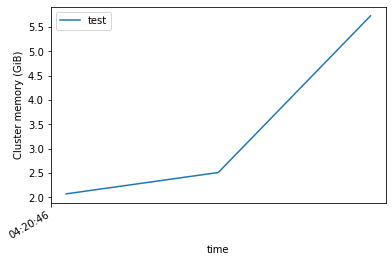

In [32]:
ms.plot()

In [14]:
df = ms.to_pandas()
#ds = df.to_xarray()

In [22]:
t = pd.Timestamp(2000)

In [23]:
type(t)

pandas._libs.tslibs.timestamps.Timestamp

In [26]:
type(df.index.to_pydatetime())

numpy.ndarray

In [27]:
#df.index.astype(pd.Timestamp)

In [30]:
df.to_csv("tmp.csv")

In [28]:
df.to_xarray()

TypeError: 'int' object is not iterable

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [6]:
#create_tiles = True
create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(5, 10), overlap=(250, 250))
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

In [ ]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G["tiles"]:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G["boundaries"]:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#ax.set_axis_off()
plt.show()

--- 

## loop over time windows (main loop)


In [7]:
# simulation parameters

T = 1 # length of the total run [days]

dt_window = timedelta(days=1.)
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dt_seed = 10 # in days

init_dij = 50 # initial position subsampling compared to llc grid

In [8]:
# restart control
restart = 0 # 0: no restart, -1: last index, precise index otherwise

In [9]:
# create run directories, erase them if need be
_overwrite=False
#if restart==0 and overwrite:
if restart==0:    
    _overwrite = True
tl.create_tile_run_tree(dirs["run"], overwrite=_overwrite)

# set start and end times
t_start = ut.np64toDate(ds["time"][0].values)
t_end = t_start + int(T/dt_window.days)*dt_window
print("Global start = {}  /  Global end = {} "
      .format(t_start.strftime("%Y-%m-%d:%H"),
              t_end.strftime("%Y-%m-%d:%H"),
             )
     )

# get new log filename for this run
log_file = pa.name_log_file(dirs["run"])

if restart==-1:
    log = pa.browse_log_files(dirs["run"])
    if log:
        restart = max(list(log))+1
    else:
        restart = 0

# clean up data for restart
tl.clean_up(dirs["run"], restart)

if restart==0:
    global_parcel_number = 0
    local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
    max_ids = {tile: None for tile in range(tl.N_tiles)}
else:
    #print(log, restart)
    _log = log[restart-1]
    global_parcel_number = _log["global_parcel_number"]
    #local_numbers = _log["local_numbers"] # TMP !!!
    max_ids = _log["max_ids"]

# debug
#id_max=None

# skips steps if restart
step_t = list(enumerate(ut.dateRange(t_start, t_end, dt_window)))[restart:]

def format_info(step, t_start, t_end):
    print("-------------------------------------------")
    print("step={}  /  start={}  /  end={}"
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

Global start = 2011-11-15:00  /  Global end = 2011-11-16:00 


In [10]:
step_window_delayed = delayed(pa.step_window)

step, local_t_start = step_t[0]

local_t_end = local_t_start+dt_window+dt_step

# print step info
format_info(step, local_t_start, local_t_end)

# load, tile (and store) llc data
ds_tiles = pa.tile_store_llc(ds,
                             slice(local_t_start, local_t_end, None),
                             tl,
                             coords = ["XG", "YG", "Depth", "CS", "SN"],
                            )
# should test how much ds_tiles represents once loaded in memory and compare it to
# the 750GB observed while running parcels

# seed with more particles
seed = ( (local_t_start-t_start).days%dt_seed == 0 )

global_parcel_number0 = global_parcel_number

-------------------------------------------
step=0  /  start=2011-11-15:00  /  end=2011-11-16:01


In [11]:
ds_tiles[0]

<xarray.Dataset>
Dimensions:  (i: 3706, j: 1521, time: 26)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 3699 3700 3701 3702 3703 3704 3705
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 1514 1515 1516 1517 1518 1519 1520
    XG       (j, i) float32 dask.array<chunksize=(1521, 3706), meta=np.ndarray>
    YG       (j, i) float32 dask.array<chunksize=(1521, 3706), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1521, 3706), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(1521, 3706), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1521, 3706), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-16T01:00:00
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1521, 3706), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 1521, 3706), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 1521, 3706), meta=np.ndarray>
    SSU      (time, j, i) float32 dask.array<chunksize=(1, 1521, 3706), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(1, 1521, 3706), meta=np.ndarray>
Attributes:
    coordinate:     YG XG
    long_name:      longitude
    standard_name:  longitude_at_f_location
    units:          degrees_east

In [12]:
# run the simulation over a single tile
tile = 13
tiles = [tile]

In [13]:
dsteps = [step_window_delayed(tile, step, 
                                  local_t_start, local_t_end,
                                  dt_window, dt_step, dt_outputs,
                                  tl,
                                  ds_tile=ds_tiles[tile], 
                                  init_dij=init_dij, 
                                  parcels_remove_on_land=True,
                                  pclass="extended",
                                  id_max=max_ids[tile],
                                  seed=seed,
                                 )
          for tile in tiles
         ]
dsteps_out = dask.compute(*dsteps)

# update number of global number of drifters and maximum ids for each tiles
_local_numbers = list(zip(*dsteps_out))[0]
global_parcel_number = sum(_local_numbers)
max_ids = {tile: int(out[1]) for tile, out in enumerate(dsteps_out)}
local_numbers = {tile: int(out) for tile, out in enumerate(_local_numbers)}
log = dict(global_parcel_number=global_parcel_number,
           local_numbers=local_numbers,
           max_ids=max_ids,
          )

# store log
pa.store_log(log_file, step, log)

print("Total number of particles = {}  ({:+d})"
      .format(global_parcel_number, 
              global_parcel_number-global_parcel_number0,
             )
     )

INFO: Compiled ArrayParticle_extendedRemoveOnLand ==> /dev/shm/pbs.8727080.datarmor0/parcels-55081/libe24cd567c9038b13a07fc304160b788d_0.so
INFO: Compiled ArrayParticle_extendedAdvectionRK4Extended_Sample ==> /dev/shm/pbs.8727080.datarmor0/parcels-55081/lib7ea80ee28810e53b520c95a171fa8f7e_0.so
INFO: Temporary output files are stored in /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/run/data_013/out-LFKCLEVP.
INFO: You can use "parcels_convert_npydir_to_netcdf /home1/scratch/aponte/global_T365j_dt1j_dij50_debug/run/data_013/out-LFKCLEVP" to convert these to a NetCDF file during the run.
100% (90000.0 of 90000.0) |##############| Elapsed Time: 0:00:40 Time:  0:00:40


Total number of particles = 1722  (+1722)


### reload data and inspect

In [14]:
df = pa.load_nc(dirs["run"], index="time", persist=True)
df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,waterdepth
time,,,,,,,,,,
2011-11-15 00:00:00,13000000,-60.772732,37.145832,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-11-15 01:00:00,13000000,-60.773947,37.143280,0.0,-0.034311,-0.039920,-0.955182,-1.852082,33.841530,5254.211426
2011-11-15 02:00:00,13000000,-60.775063,37.141613,0.0,-0.015978,-0.029105,-0.957582,-1.852189,33.841389,5254.211426
2011-11-15 03:00:00,13000000,-60.775699,37.141297,0.0,0.006505,-0.010176,-1.014567,-1.852216,33.841637,5254.211426
2011-11-15 04:00:00,13000000,-60.775922,37.141986,0.0,0.014256,-0.003575,-1.126799,-1.852351,33.841690,5254.211426


In [15]:
t = df.index.unique().compute().dropna()[10]

In [16]:

def plot(delta):
    #delta = 0

    ds1 = ds_tiles[tile].sel(time=t-pd.Timedelta("1H")*delta)
    df1 = df.loc[str(t)]

    #ds1 = ds1.isel(i=slice(1000,2000,3), j=slice(1000,2000,3))
    ds1 = ds1.isel(i=slice(1000,2000,3), j=slice(0,2000,3))

    bounds = [float(ds1.XG.min()), float(ds1.XG.max()), 
              float(ds1.YG.min()), float(ds1.YG.max())]
    df1 = df1.loc[ (df1.lon>bounds[0]) & (df1.lon<bounds[1]) 
                  & (df1.lat>bounds[2]) & (df1.lat<bounds[3])]

    #ds1["zonal_velocity"], ds1["meridional_velocity"] = ds1.SSU, ds1.SSV
    ds1["zonal_velocity"], ds1["meridional_velocity"] = ut.rotate(ds1.SSU, ds1.SSV, ds1)

    ds1 = ds1.persist()
    df1 = df1.compute()

    print(f"llc time = {ds1.time.values}")
    print(f"parcels time = {df1.reset_index().time.unique()[0]}")

    #kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)
    kwargs = dict(vmin=-1.5, vmax=1., cmap=pl.cm.balance)
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ds1["Eta"].plot(x="XG",y="YG", ax=ax, **kwargs)
    ax.scatter(df1.lon, df1.lat, s=5, c=df1["sea_level"], **kwargs)

    #kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)
    kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ds1["zonal_velocity"].plot(x="XG",y="YG", ax=ax, **kwargs)
    ax.scatter(df1.lon, df1.lat, s=5, c=df1["zonal_velocity"], **kwargs)

llc time = 2011-11-15T10:00:00.000000000
parcels time = 2011-11-15T10:00:00.000000000


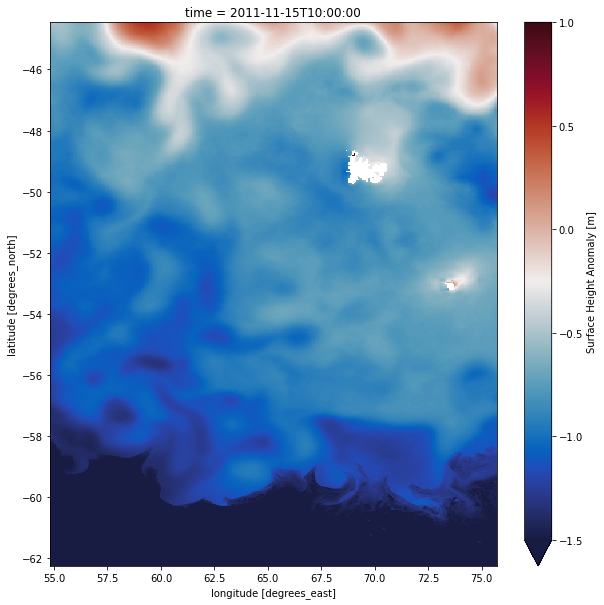

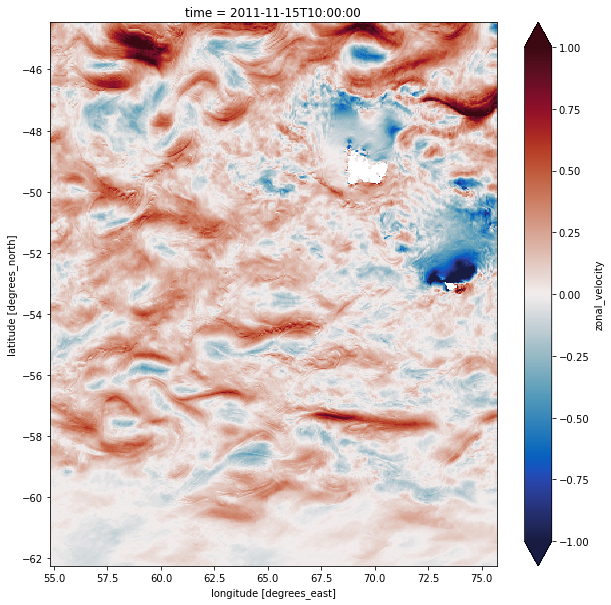

In [17]:
# ds
plot(0)

llc time = 2011-11-15T09:00:00.000000000
parcels time = 2011-11-15T10:00:00.000000000


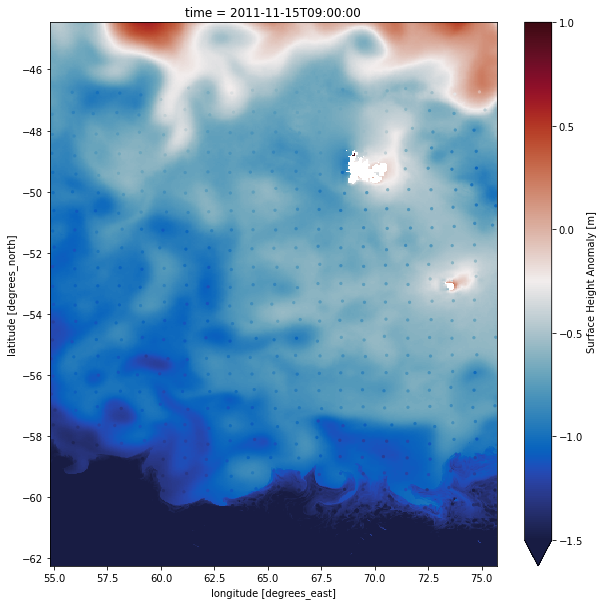

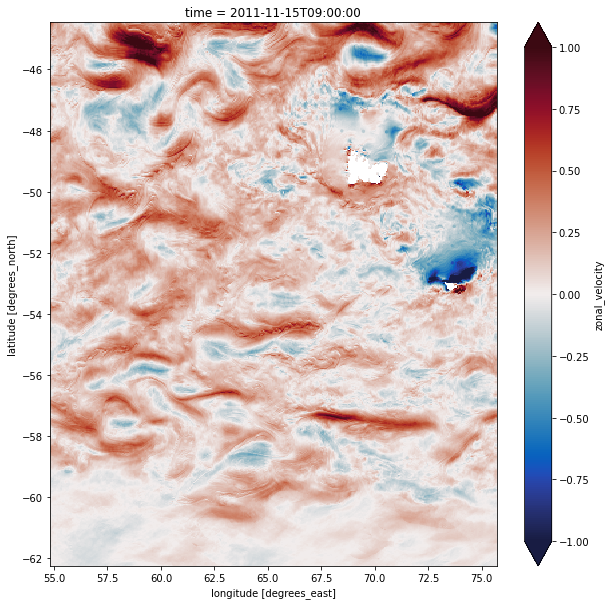

In [18]:
# ds-1h
plot(1)

In [5]:
df = pa.load_nc(dirs["run"], index="time", persist=True)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
tmin = str(df.index.min().compute() + timedelta(days=1.))
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-16 00:00:00 2012-11-09 01:00:00


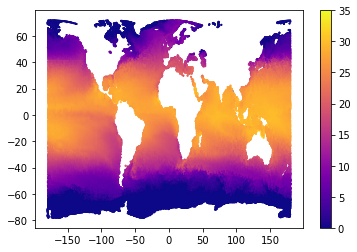

In [8]:

_df = df.loc[tmin].compute()
plt.scatter(_df["lon"], _df["lat"], s=1, c=_df["temperature"], 
            vmin=0, vmax=35, cmap="plasma")
plt.colorbar()

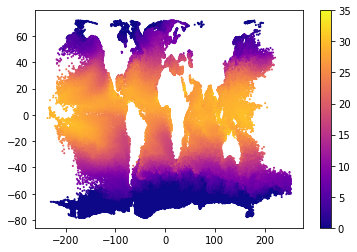

In [9]:
_df = df.loc[tmax, :].compute()
plt.scatter(_df["lon"], _df["lat"], s=1, c=_df["temperature"], 
            vmin=0, vmax=35, cmap="plasma")
plt.colorbar()

## Close cluster

In [ ]:
cluster.close()